In [0]:
# --- Setup PySpark ---
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, col, sum, coalesce, when
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [0]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Handling Missing Data") \
    .getOrCreate()

In [0]:
# --- Load Dataset (1000 rows with missing values) ---
file_path = "/Volumes/workspace/csv_files/csv_files/missing_data_1000.csv"  
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [0]:
print("Original Data Sample:")
df.show(10)

Original Data Sample:
+---+-------+---+------+
| id|   name|age|salary|
+---+-------+---+------+
|  1|   NULL| 59| 58500|
|  2|  David| 34| 40500|
|  3|    Eve| 22| 93000|
|  4|   NULL| 46| 31000|
|  5|Charlie| 21| 93000|
|  6|    Eve| 27| 50000|
|  7|    Eve| 34| 82500|
|  8|   NULL| 27| 36500|
|  9|    Bob| 34| 35500|
| 10|Charlie| 37| 73000|
+---+-------+---+------+
only showing top 10 rows


In [0]:
print(df.count(),len(df.columns))

1000 4


In [0]:
# create null indicators
missing_counts = df.select([col(c).isNull().cast("int").alias(c) for c in df.columns])

# aggregate and keep original column names
missing_counts = (
    missing_counts.groupBy()
    .agg(*[sum(c).alias(c) for c in missing_counts.columns])  # to keep original names, When you write a list comprehension inside .agg(), 
    you must unpack it with * so each expression is passed individually.
    .toPandas()
    .T #transpose
    .reset_index()
)

missing_counts.columns = ["column", "missing_count"]

missing_counts.head()

,column,missing_count
0,id,0
1,name,138
2,age,22
3,salary,9


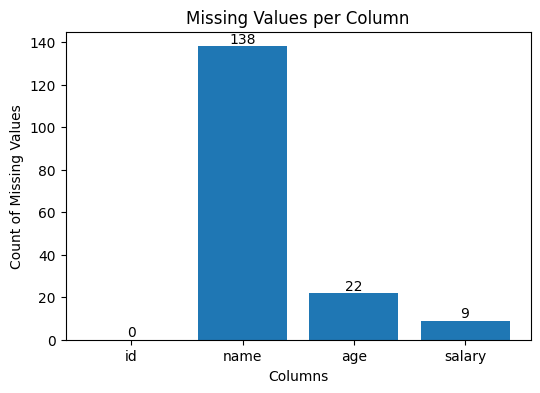

In [0]:
# --- Visualization 1: Missing Data Count per Column ---
plt.figure(figsize=(6,4))

bars = plt.bar(missing_counts["column"], missing_counts["missing_count"])

plt.title("Missing Values per Column")
plt.xlabel("Columns")
plt.ylabel("Count of Missing Values")

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # x: middle of bar
        height,                           # y: top of bar
        str(height),                      # text label
        ha="center", va="bottom"          # align center, just above bar
    )

plt.show()

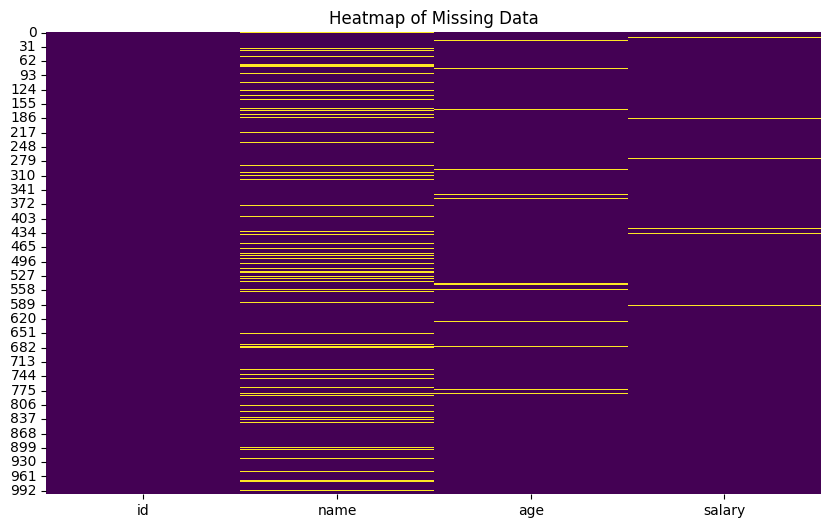

In [0]:
# --- Visualization 2: Heatmap of Missing Values ---
pdf = df.toPandas()

plt.figure(figsize=(10,6))
sns.heatmap(pdf.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Data")
plt.show()

Technique 1: Drop Missing Data

In [0]:
#1
print("Drop rows with ANY null:")
df_drop_any = df.na.drop(how="any")
df_drop_any.show(5)

#2
print("Drop rows with ALL null:")
df_drop_all = df.na.drop(how="all")
df_drop_all.show(5)

Drop rows with ANY null:
+---+-------+---+------+
| id|   name|age|salary|
+---+-------+---+------+
|  2|  David| 34| 40500|
|  3|    Eve| 22| 93000|
|  5|Charlie| 21| 93000|
|  6|    Eve| 27| 50000|
|  7|    Eve| 34| 82500|
+---+-------+---+------+
only showing top 5 rows
Drop rows with ALL null:
+---+-------+---+------+
| id|   name|age|salary|
+---+-------+---+------+
|  1|   NULL| 59| 58500|
|  2|  David| 34| 40500|
|  3|    Eve| 22| 93000|
|  4|   NULL| 46| 31000|
|  5|Charlie| 21| 93000|
+---+-------+---+------+
only showing top 5 rows


Technique 2: Fill Missing Data

In [0]:
print("Fill missing with constant values:")
df_fill = df.na.fill({"age": 0, "salary": 0, "name": "Unknown"})
df_fill.show(5)

Fill missing with constant values:
+---+-------+---+------+
| id|   name|age|salary|
+---+-------+---+------+
|  1|Unknown| 59| 58500|
|  2|  David| 34| 40500|
|  3|    Eve| 22| 93000|
|  4|Unknown| 46| 31000|
|  5|Charlie| 21| 93000|
+---+-------+---+------+
only showing top 5 rows


Technique 3: Fill with Mean/Median (Numeric Columns)

In [0]:
mean_age = df.select(mean(df['age'])).collect()[0][0]
mean_salary = df.select(mean(df['salary'])).collect()[0][0]

print("Fill missing with column means:")
df_mean = df.na.fill({"age": mean_age, "salary": mean_salary})
df_mean.show(5)

Fill missing with column means:
+---+-------+---+------+
| id|   name|age|salary|
+---+-------+---+------+
|  1|   NULL| 59| 58500|
|  2|  David| 34| 40500|
|  3|    Eve| 22| 93000|
|  4|   NULL| 46| 31000|
|  5|Charlie| 21| 93000|
+---+-------+---+------+
only showing top 5 rows


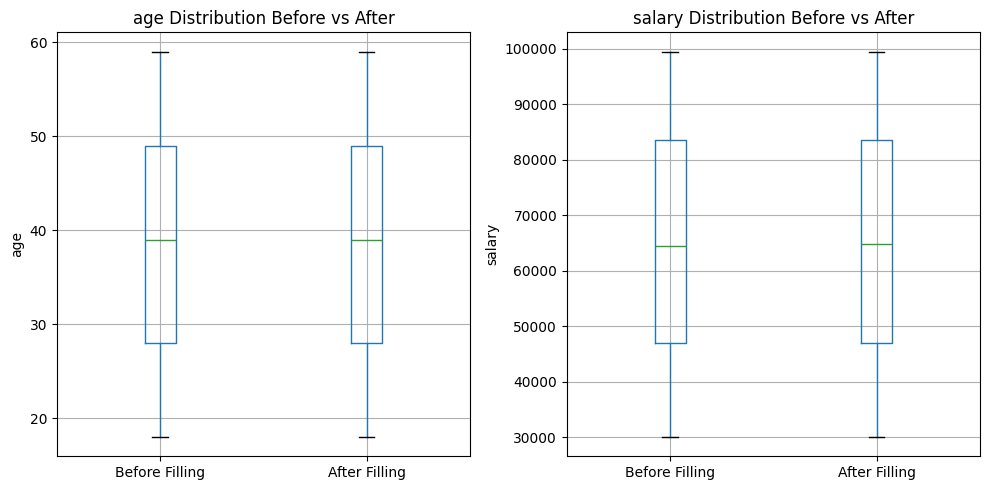

In [0]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrames to Pandas
original = df.toPandas()
filled = df_mean.toPandas()

variables = ["age", "salary"]
scale_salary = 1000

plt.figure(figsize=(10, 5))

for i, var in enumerate(variables, 1):
    plt.subplot(1, 2, i)
    
    # Combine before and after into one DataFrame for Seaborn / matplotlib boxplot
    data = pd.DataFrame({
        "Before Filling": original[var],
        "After Filling": filled[var] if var != "salary" else filled[var]
    })
    
    data.boxplot()
    plt.title(f"{var} Distribution Before vs After")
    plt.ylabel(var)

plt.tight_layout()
plt.show()

#This likely means that either:

#There were very few missing age values, or

#The missing values were close to the mean anyway.

# Key takeaway: Filling age did not distort the distribution.


Technique 4: Conditional Filling (e.g., by group)

In [0]:
# Step 1: Mark rows where age is null
df_conditional = df.withColumn("age_was_null", when(col("age").isNull(), 1).otherwise(0))

# Step 2: Compute mean age per name
avg_age = df.groupBy("name").agg(mean("age").alias("avg_age"))

# Step 3: Join and fill missing age with group mean
df_conditional = df_conditional.join(avg_age, on="name", how="left") \
                               .withColumn("age_filled", coalesce(col("age"), col("avg_age")))

df_conditional = df_conditional.fillna({"age_filled": 0})
df_conditional.show(5)

+-------+---+---+------+------------+------------------+----------+
|   name| id|age|salary|age_was_null|           avg_age|age_filled|
+-------+---+---+------+------------+------------------+----------+
|   NULL|  1| 59| 58500|           0|              NULL|      59.0|
|  David|  2| 34| 40500|           0|39.026490066225165|      34.0|
|    Eve|  3| 22| 93000|           0| 38.31506849315068|      22.0|
|   NULL|  4| 46| 31000|           0|              NULL|      46.0|
|Charlie|  5| 21| 93000|           0|        37.9765625|      21.0|
+-------+---+---+------+------------+------------------+----------+
only showing top 5 rows


In [0]:
# Step 4: Show only rows where age was null, with relevant info
df_conditional.filter(col("age_was_null") == 1).select(
    "name", "age", "avg_age", "age_filled"
).show(truncate=False)

+-------+----+------------------+------------------+
|name   |age |avg_age           |age_filled        |
+-------+----+------------------+------------------+
|Alice  |NULL|36.9025974025974  |36.9025974025974  |
|Alice  |NULL|36.9025974025974  |36.9025974025974  |
|NULL   |NULL|NULL              |0.0               |
|NULL   |NULL|NULL              |0.0               |
|NULL   |NULL|NULL              |0.0               |
|NULL   |NULL|NULL              |0.0               |
|NULL   |NULL|NULL              |0.0               |
|Bob    |NULL|40.02238805970149 |40.02238805970149 |
|Bob    |NULL|40.02238805970149 |40.02238805970149 |
|Bob    |NULL|40.02238805970149 |40.02238805970149 |
|Charlie|NULL|37.9765625        |37.9765625        |
|Charlie|NULL|37.9765625        |37.9765625        |
|Eve    |NULL|38.31506849315068 |38.31506849315068 |
|Eve    |NULL|38.31506849315068 |38.31506849315068 |
|Frank  |NULL|38.20454545454545 |38.20454545454545 |
|Frank  |NULL|38.20454545454545 |38.2045454545